# Data Analytics

## Machine Learning & Statistics Project


<b>Project requirement:</b> The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.


<b>import the required packages for the program</b>

In [1]:
# For data frames.
import pandas as pd
import seaborn as sns

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt
#%matplotline inline

#For maths
import math as m

# For linear regression.
from sklearn import linear_model

# For evaluating model performance.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

# For splitting data into train / test sets.
from sklearn.model_selection import train_test_split
#import sklearn.model_selection as skms

from scipy.optimize import curve_fit
from scipy import stats
import sklearn.preprocessing as skpp
import sklearn.metrics as skme
import tensorflow.keras as kr
from keras.models import model_from_json
from tensorflow.keras.models import Sequential 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
plt.rcParams['figure.figsize'] = (8.0, 6.0) 

<b>PowerProduction Dataset</b>


In [3]:
# File provided as a txt file. I saved it as a csv file.
Power_data = pd.read_csv("data\powerproduction.csv")

# Make a copy of the original dataset in case we need it later.
Power_data_copy = Power_data

# Size?
shape = Power_data.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(Power_data.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [4]:
# Have a look at the data from our Power Production input
Power_data

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


Since the power column has zero output from the above we will check few lines from top and bottom of the file



In [5]:
# Print firdt 20 rows
Power_data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
Power_data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


Looking at the raw data it is noted that wind speeds 0.275 and below generate no power, wind speeds 24.499 generate no power. Even from the above description the power for the low and high level wind speed power has taken zero value. So we will look at some more rows from the top to find the data for Power column.

In [7]:
# Look at some quick descriptive statistics of the numeric data.
print(Power_data.describe())

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6.324750    5.288000
50%     12.550500   41.645500
75%     18.775250   93.537000
max     25.000000  113.556000


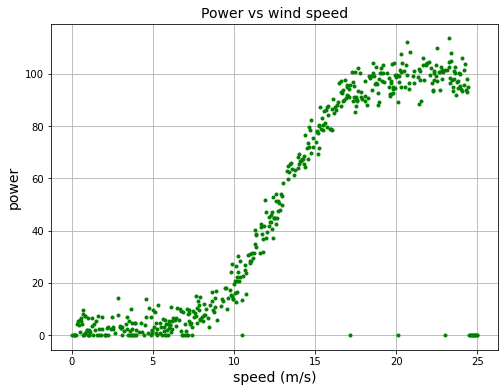

In [8]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(Power_data['speed'], Power_data['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

With the given data we can see that there is little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (8 - 17 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed. 

I would like to do some cleanup to remove the zero power just to make it clear while finding the promising model

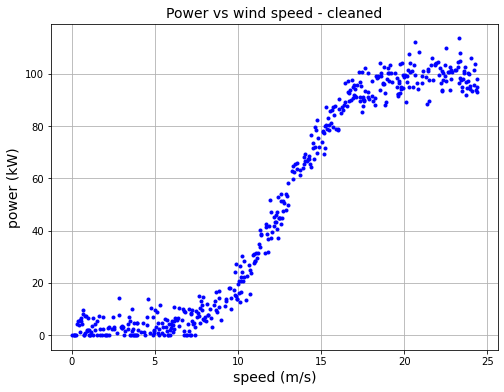

In [9]:
# Remove the rows with zero values to Power column from my existing dataset.
Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Power_data['speed'], Power_data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

<b>Formula used in real life to calculate the Power of Wind</b>

In order to calculate the amount of energy the wind speed is very important to convert it to electricity. The energy content of the wind varies with the cube of the avereate  wind speed, e.g. if the wind speed is twice as high it contains 2^3 = 2x2x2 = eight times as much energy [1]



![Power_of_wind](images/Power_of_wind.jpg)


<b>Power Curve of a Wind Turbine</b>

The power curve of a wind turbine is a graph that indicates how large the electrical power output will be for the turbine at different wind speeds[2] At the same time this curve will not show how much power a wind turbine will produce at a certain average wind speed.

When the anemometer registers wind speeds higher than 25 mph (cut-out speed varies by turbine), it triggers the wind turbine to automatically shut off and resumes back to normal when the measurement of wind speed are at or below the turbine's cut-out speed[4]  

![Power_curve](images/Power_curve.jpg)

![Power_curve2](images/Wind_Power_curve.jpg)

The theoretical power curve for a turbine is specific to each turbine and site [3]. Based on the above graph  
 - The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 4 m/s.
 - The rated output power is achieved at approximately 14 - 15 m/s.
 - The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.
 
While comparing this curve with the plot diagram on our cleaned dataset is nearly closer but we will start to apply some regression methods to find the best model for our Power production dataset.

## Prepare Dataset to find a best model in ML

In order to prepare our dataset for investigations, it is better to remove unwanted results like zero output from it to find a best model. So that I am going to use the last cleaned dataset hear after.

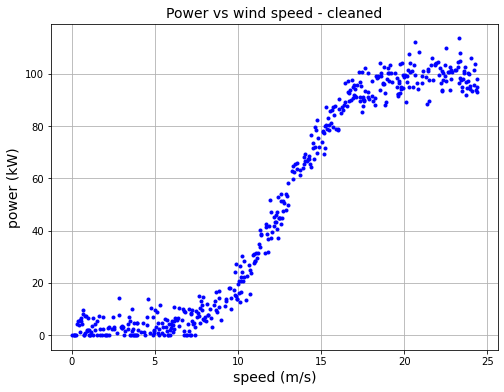

In [10]:
# Remove the rows with zero values to Power column from my existing dataset.
Cleaned_Power_Data =  Power_data

#Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Cleaned_Power_Data['speed'], Cleaned_Power_Data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

### Model 1 - Linear Regression

#### Applying Linear regression 

Linear regression uses the relationship between the data-points to draw a straight line through all them. This line can be used to predict future values. It is a very powerful technique and can be used to understand the factors that influence profitability.[5] 


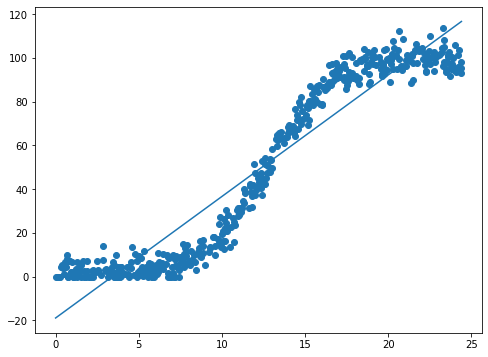

In [11]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp
x = Power_data['speed'].tolist()
y = Power_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

From the above graph, you will a line straight in the middle of the data, means that there are large parts of the data untouched by the line where a linear prediction of the coordinates of speed to power would be very out of sync with where most of the data is. 

If we try to eliminate the data where speed and power are zero then we could get a good model with linear regression.

<b>Preparing Medium data set by including data for Speed within 7 m/s to 17m/s </b>

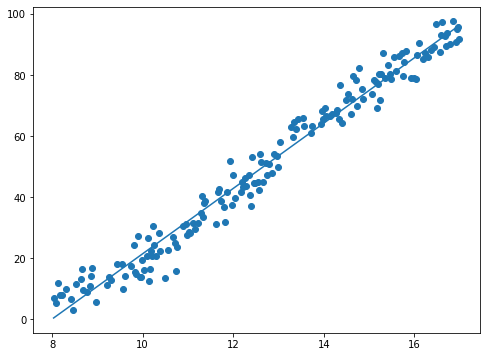

In [12]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp

# Cleaniing the dataset by removing the zero values
cleansed_data = Power_data.loc[Power_data['power'] > 0 ]

Medium_set_data = cleansed_data.loc[(cleansed_data['speed'] > 8) & (cleansed_data['speed']<= 17)]

x = Medium_set_data['speed'].tolist()
y = Medium_set_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()


In [13]:
Medium_set_data.describe().round(2)

,speed,power
count,172.00,172.00
mean,12.66,49.93
std,2.58,27.97
min,8.03,3.00
25%,10.38,24.26
50%,12.55,47.31
75%,14.92,76.70
max,16.99,97.53


In [14]:
# Count low medium and high wind speed ranges. Code adapted from
# https://www.kite.com/python/answers/how-to-count-the-number-of-rows-in-a-pandas-dataframe-in-python
df_cnt = len(Power_data.index)

med_s_cnt = len(Medium_set_data.index)

# Print % of low medium and high wind speed ranges.
# Code adapted from https://pyformat.info/
print(f"Medium speed range: 8 to 17 m/s = {(med_s_cnt/df_cnt)*100:.1f}%")


Medium speed range: 8 to 17 m/s = 35.4%


<b> Summary plot of relationship for Medium Wind Speed range </b>

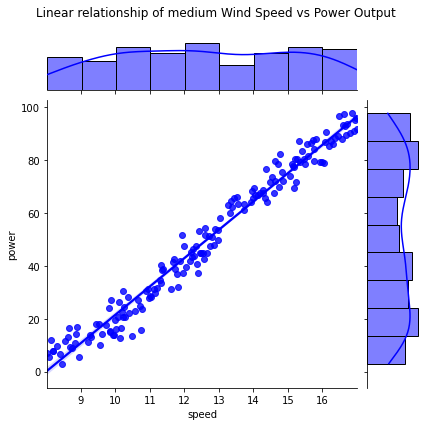

In [15]:
# Plot comparison of medium wind speed versus power output
# Code adapted from https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-distributions 
# and https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot
plot = sns.jointplot(x="speed", y="power", kind="reg", color="b", height=6, data=Medium_set_data)

# Add Title adapted from https://stackoverflow.com/a/52096280
plt.subplots_adjust(top=0.90)
plt.suptitle("Linear relationship of medium Wind Speed vs Power Output", fontsize = 12)
# Display plot
plt.show()


<b> Display plot of cleaned full dataset </b>

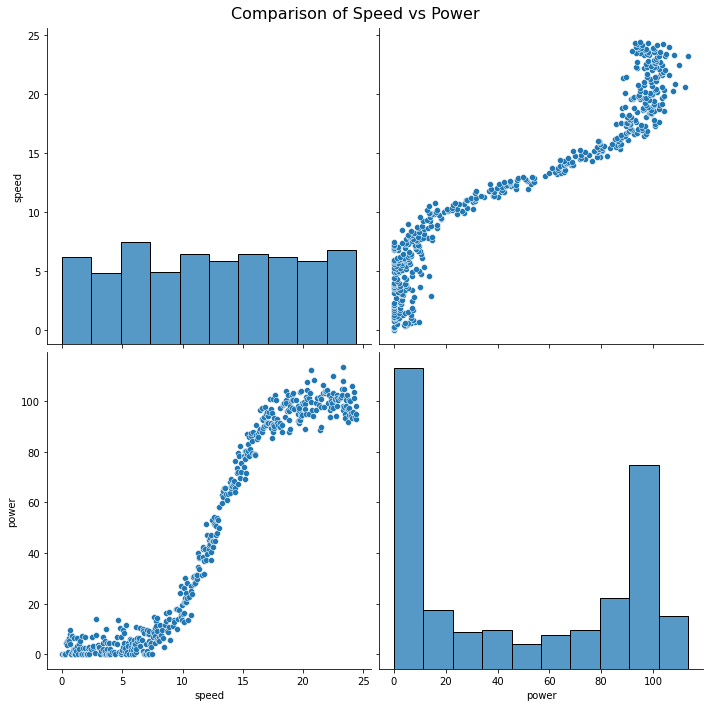

In [16]:
# Replot data comparison 
plot = sns.pairplot(Power_data, height=5)
# Add Title 
plt.subplots_adjust(top=0.95)
plt.suptitle("Comparison of Speed vs Power", fontsize = 16)
plt.show()

#### Splitting Full Data Set into Training Data and Test Data

Using scikit-learn we can divide the Power Production data set into training data and test data. 

In [17]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Power_data[["speed"]]
y = Power_data["power"]

print(x.shape)
print(y.shape)

#Split 70% of data into training set and 30% of data into test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()



(486, 1)
(486,)
Coefficients: 
 [5.56118925]
Intercept: 
 -19.145311145439926


,Actual,Predicted
264,64.541,55.029831
110,0.000,13.003924
416,112.362,95.671002
186,14.055,34.297718
292,72.135,63.521767


<b>Evaluating the Algorithm</b>

The final step is to evaluate the performance of algorithm. This step is particularly important to compare how well different algorithms perform on a particular dataset. For regression algorithms, three evaluation metrics are commonly used:
 - Mean Absolute Error (MAE)
 - Mean Squared Error (MSE)
 - Root Mean Squared Error (RMSE)
 

<b>Applying evaluation on the full data set</b>

In [18]:
# Code adopted from https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 11.202280128426883
Mean Squared Error: 161.3889303695446
Root Mean Squared Error: 12.703894299369175


You can see that the value of root mean squared error is 12.29, which is around 25% of the mean value of the percentages of Power energy which is 49.39. From this result we can see the impact of zero values for Speed and Power. If we get less than around 10% of Mean value of the actual dataset then it would be a good mode;

Since the Mean squared error from out full data set is too high, I am going to take the Medium Data set to find it's performance.

<b>Apply Train test on Medium Power data set</b>

In [19]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Medium_set_data[["speed"]]
y = Medium_set_data["power"]

print(x.shape)
print(y.shape)

#Split 70% of data into training set and 30% of data into test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()


(172, 1)
(172,)
Coefficients: 
 [10.54313944]
Intercept: 
 -83.33101453109232


,Actual,Predicted
256,50.658,51.494653
294,78.284,76.028538
266,65.605,58.347693
222,34.693,35.658857
253,44.880,50.176760


<b>Evaluating the Algorithm</b>

In [20]:
# Code adopted from https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 3.9499027065770216
Mean Squared Error: 24.470559024616907
Root Mean Squared Error: 4.946772586709127


From the result above we can see that the value of root mean squared error is 5.03, which is around 10% of the mean value of the percentages of Power energy which is 49.39.

From the above predictions and investigations it is clear that applying linear regression on a large set of data will not be good and it is quite good when there is no invalid data and a small set of data.

So that I have done few more research in the available models in Machine Learning and found that Neural network has a high performance than the other traditional algorithms. So that I am moving on the Neural network model in the next step.

### Model 2 - Neural Network model

### Machine learning methods for wind turbine condition monitoring

The ML model selection step is particularly significant as it is the core functionality that learns from past data and generalizes into the future. Such models have been used for different tasks, including classification, regression, anomaly detection, synthesis and sampling, imputation of missing values, denoising, density estimation and many others. Several different models have been suggested for learning from data. Support vector machines (SVMs) and neural networks (NNs) are two common models that have been used in ML for diagnostics and prognostics.[6].


While searching for a good model that can fit into out dataset, I found that Neural network has a better performance than the other traditional models. Since Deep Neural Network models are capable of learning complex non-linear functions, it may achieve better performance.[8]

#### Deep Learning in Keras

Deep learning is one of the most interesting and promising areas of artificial intelligence(AI) and machine learning currently. [7] It is a subfield of machine learning, and Neural Networks make up the backbone of deep learning algorithms. 
A deep learning neuual network is just a neural network with many hidden layers.

- <b>Number of layers :</b>
    In this model I am going to use Dense layer.
- <b>Types of these layers :</b>
    Dense layers are the most common and popular type of layers and it's just a regular neural network layer where each of its neurons is connected to the neurons of the previous and next layers.
- <b>Number of units (neurons) in each Layer :</b>
    Each dense layer has an activation function that determines the output of its neurons based on the inputs and the weights of the synapses.
- <b>Activation Functions of each Layer :</b>
    Activation functions are used to calculate a "weighted sum" of its input, adds a bias and then decides whether it should be activated or not. 
- <b>Input and output size :</b>
    Neural network consisting of three layers: the input layer, a hidden layer with 50 neurons, and the output layer. The size of the input and output layers is determined by the data we have and what we want to predict. Having one hidden layer is a good default, but if there are more hidden layers, it's recommended to have the same number of neurons in each hidden layer
 

![Neural_network](images/Neural_network.jpg)

### Activation Function selected for this model

When we are using connected layers in our model and if we use Linear activation on each layer then it will turn into one layer at the end. So that we have to apply a different activation function when using connected layers.

There are different activation functions, e.g, Relu, Than and Sigmoid are in use now a days. 

Sigmoid - It is nonlinear in nature and combination of this function are also nonlinear. It will give an anolog activation unlike step function and it has a smooth gradient. The output of this function is always going to be in raning (0,1) and and we will have our activations bound in a range.[9]

Tanh - It is actually a scaled sigmoid function, where it is also nonlinear and great to stack layers. It is bound to range (-1,1) like sigmoid but Tanh has stronger gradient than Sigmoid. 

Relu - The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero[10]

#### Sigmoid Activation

![Sigmoid](images/Sigmoid.jpg)

Activation function takes every neuron as linear neuron input and generates a nonlinear output based in it, often deterministically. Sigmid activation function uses the above formula and also known as the logistic curve.

As in the plot the function slowly increases over time, but the greatest increase can be found around x=0. The range of the function is (0,1) i.e, towards high values for x the funciton therefore approaches 1, but never equals it. [11]

<b>Sigmoid Curve Model Dataset Pre-Processing</b>

In [21]:
# Create sigmoid curve df
Sigmoid_power_data = Power_data.copy()

# Divide the data into input and output values. Code adapted from https://stackoverflow.com/a/64042705
x_S = Sigmoid_power_data['speed'].values
y_S = Sigmoid_power_data['power'].values

# Split the dataset into training and test datasets. Code adapted from
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train_S, x_test_S, y_train_S, y_test_S = train_test_split(x_S, y_S, test_size= 0.3, random_state=0)

# Set power output value normalisation scaler values, to approximate upper asymptote [9]
SpoF = 100

# normalise output values
y_train_S = y_train_S / SpoF
y_test_S = y_test_S / SpoF

<b>Sigmoid Curve Model Training</b>

In [22]:
# Create sigmoid curve model. Code adapted from https://stackoverflow.com/a/4308333 &
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

# Define a function for sigmoid output
def sigmoid(x, k, x0):
    """ Function to return scaled (0 to 1) power output based
        on input 'x', a numpy array of wind speed number/s with
        'k' and 'x0' number modifiers from the scipy curve_fit function
    """
    return 1.0 / (1 + np.exp(-k * (x - x0)))

# Fit the training data to the curve
popt, pcov = curve_fit(sigmoid, x_train_S, y_train_S)

# Extract the scipy curve_fit function 'k' and 'x0'
# number modifiers from the fitted curve
est_k, est_x0 = popt

# Predict the fitted curve values for the training and test datasets using
# the extracted scipy curve_fit function 'k' and 'x0'
# number modifiers from the fitted curve
y_train_S_predict = sigmoid(x_train_S, k=est_k, x0=est_x0)*SpoF
y_test_S_predict = sigmoid(x_test_S, k=est_k, x0=est_x0)*SpoF

<b>Sigmoid Curve Model Testing</b>

In [23]:
# Check Mean Squared error for training and test datasets
print(f"Sigmoid curve fiting Mean Squared Error for training model is {skme.mean_squared_error(y_train_S, y_train_S_predict):.3f}")
print(f"Sigmoid curve fiting Mean Squared Error for testing data is {skme.mean_squared_error(y_test_S, y_test_S_predict):.3f}")

# Testing of the model prediction
print(f"\nWind speed of 20 using the Sigmoid model gives power of: {sigmoid(np.array([20]), k=est_k, x0=est_x0)[0]*SpoF:.3f}")

Sigmoid curve fiting Mean Squared Error for training model is 4079.801
Sigmoid curve fiting Mean Squared Error for testing data is 3890.338

Wind speed of 20 using the Sigmoid model gives power of: 97.989


<b>Sigmoid Curve Model Display Plot using Train and Test Dataset </b>

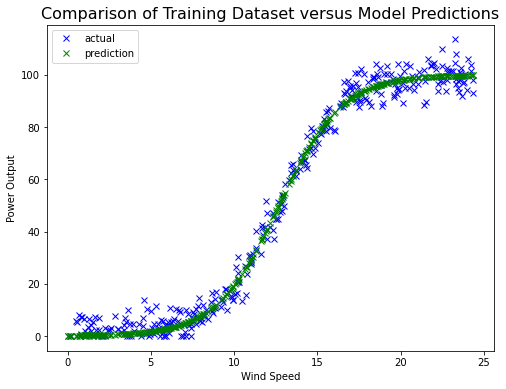

In [24]:
# Plot training dataset comparison
plt.plot(x_train_S, y_train_S*SpoF, 'bx', label='actual')
plt.plot(x_train_S, y_train_S_predict, 'gx', label='prediction')
plt.title("Comparison of Training Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

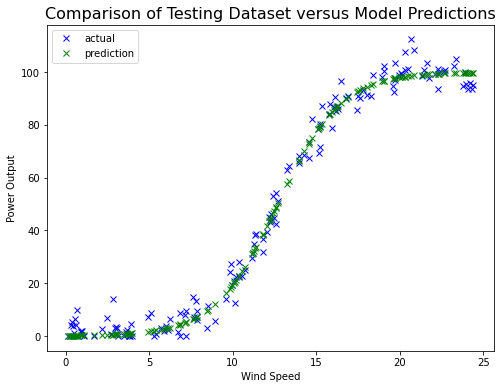

In [25]:
# Plot testing dataset comparison
plt.plot(x_test_S, y_test_S*SpoF, 'bx', label='actual')
plt.plot(x_test_S, y_test_S_predict, 'gx', label='prediction')
plt.title("Comparison of Testing Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

#### Prepare Dataset for Keras Model:

The following models use the python tensorflow Keras machine learning module to train the models on one part of the dataset and use the remaining part of the dataset to test the model.

In [26]:
# Normalise the data for use in Keras neural network models

# Set normalisation factors [12]
Speed_F = 25
Power_F = 120

# Apply normalisation to the input speeds
Power_data_Normalise = Power_data.copy()
Power_data_Normalise['speed'] = Power_data_Normalise['speed']/Speed_F
Power_data_Normalise['power'] = Power_data_Normalise['power']/Power_F

# Divide the data into training and testing sets. Code adapted from
# https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/
# Creating a training dataframe with 70% ratio of
train = Power_data_Normalise.sample(frac = 0.7)
  
# Creating testing dataframe with rest of the 30% values 
test = Power_data_Normalise.drop(train.index)

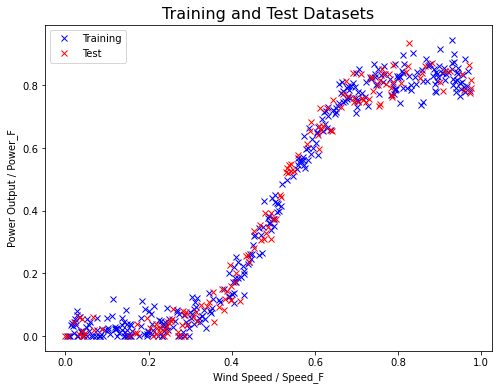

In [27]:

# Plot of training and test data
plt.plot(train['speed'], train['power'], 'bx', label='Training')
plt.plot(test['speed'], test['power'], 'rx', label='Test')
plt.title("Training and Test Datasets", fontsize = 16)
plt.xlabel("Wind Speed / Speed_F")
plt.ylabel("Power Output / Power_F")
plt.legend();


<B>Applying Keras Model</B>


In [28]:
#code adopted from https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/
# Need x and y in correct format.
X = Power_data[["speed"]] # note dimensions
y = Power_data["power"]

# Split the data set into train/set. 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Take some of the training set to be a validation set. 25% of 80 = 60 
# Want train:test:validation = 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(291, 1)
(291,)
(98, 1)
(98,)
(97, 1)
(97,)


In [29]:
# Create basic Keras main model Code adpted from https://stackoverflow.com/a/59148584
model = kr.models.Sequential()
# Add 1st Hidden layer
model.add(kr.layers.Dense(20, input_shape=(1,), activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add 2nd Hidden layer
model.add(kr.layers.Dense(20, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add Output layer
model.add(kr.layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Compile model
#model.compile('adam', loss='mean_squared_error')
model.compile('adam', loss='mean_squared_error',metrics=['accuracy'])
print("Keras Main Model Summary")
print("============================")
model.summary()



Keras Main Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


Once the model is designed, we must compile it to specify the learning rate and loss function, the quantity we are trying to minimize in through training of the network.

In [30]:
# Train the Keras main model on the training dataset.
history = model.fit(train['speed'], train['power'], epochs=500, batch_size=10)


#model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, validation_data=(X_test,y_test))
#history = model.fit(X_train, y_train, epochs=500, batch_size=10,  verbose=1, validation_data=(X_test,y_test) )
#Copied from Accuracy section
#history = model.fit(train['speed'], train['power'], epochs=35, batch_size=10,verbose=1, validation_data=(train['speed'], train['power']))


Epoch 1/500
34/34 [==============================] - 0s 485us/step - loss: 0.1231 - accuracy: 0.0880
Epoch 2/500
34/34 [==============================] - 0s 424us/step - loss: 0.1204 - accuracy: 0.0837
Epoch 3/500
34/34 [==============================] - 0s 424us/step - loss: 0.1220 - accuracy: 0.1011
Epoch 4/500
34/34 [==============================] - 0s 424us/step - loss: 0.1218 - accuracy: 0.1143
Epoch 5/500
34/34 [==============================] - 0s 394us/step - loss: 0.1176 - accuracy: 0.0708
Epoch 6/500
34/34 [==============================] - 0s 424us/step - loss: 0.1172 - accuracy: 0.0674
Epoch 7/500
34/34 [==============================] - 0s 424us/step - loss: 0.1155 - accuracy: 0.0796
Epoch 8/500
34/34 [==============================] - 0s 424us/step - loss: 0.1139 - accuracy: 0.0878
Epoch 9/500
34/34 [==============================] - 0s 424us/step - loss: 0.1070 - accuracy: 0.1001
Epoch 10/500
34/34 [==============================] - 0s 424us/step - loss: 0.1047 - accura

34/34 [==============================] - 0s 424us/step - loss: 0.0024 - accuracy: 0.1025
Epoch 161/500
34/34 [==============================] - 0s 394us/step - loss: 0.0018 - accuracy: 0.0710
Epoch 162/500
34/34 [==============================] - 0s 424us/step - loss: 0.0021 - accuracy: 0.0803
Epoch 163/500
34/34 [==============================] - 0s 394us/step - loss: 0.0019 - accuracy: 0.0970
Epoch 164/500
34/34 [==============================] - 0s 394us/step - loss: 0.0020 - accuracy: 0.0845
Epoch 165/500
34/34 [==============================] - 0s 424us/step - loss: 0.0021 - accuracy: 0.0847
Epoch 166/500
34/34 [==============================] - 0s 424us/step - loss: 0.0020 - accuracy: 0.0808
Epoch 167/500
34/34 [==============================] - 0s 424us/step - loss: 0.0019 - accuracy: 0.0730
Epoch 168/500
34/34 [==============================] - 0s 424us/step - loss: 0.0021 - accuracy: 0.0803
Epoch 169/500
34/34 [==============================] - 0s 424us/step - loss: 0.0021 - a

34/34 [==============================] - 0s 394us/step - loss: 0.0016 - accuracy: 0.0586
Epoch 318/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - accuracy: 0.0775
Epoch 319/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015 - accuracy: 0.0549
Epoch 320/500
34/34 [==============================] - 0s 424us/step - loss: 0.0014 - accuracy: 0.0819  
Epoch 321/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013 - accuracy: 0.0926
Epoch 322/500
34/34 [==============================] - 0s 424us/step - loss: 0.0012 - accuracy: 0.0848  
Epoch 323/500
34/34 [==============================] - 0s 424us/step - loss: 0.0015 - accuracy: 0.0905
Epoch 324/500
34/34 [==============================] - 0s 424us/step - loss: 0.0014 - accuracy: 0.0864
Epoch 325/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - accuracy: 0.0742
Epoch 326/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015

34/34 [==============================] - 0s 424us/step - loss: 0.0012 - accuracy: 0.0794
Epoch 476/500
34/34 [==============================] - 0s 485us/step - loss: 0.0013 - accuracy: 0.0905
Epoch 477/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - accuracy: 0.0825
Epoch 478/500
34/34 [==============================] - 0s 424us/step - loss: 0.0011 - accuracy: 0.0978
Epoch 479/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - accuracy: 0.0761
Epoch 480/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013 - accuracy: 0.0942
Epoch 481/500
34/34 [==============================] - 0s 424us/step - loss: 0.0012 - accuracy: 0.1039
Epoch 482/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - accuracy: 0.0736
Epoch 483/500
34/34 [==============================] - 0s 424us/step - loss: 0.0011 - accuracy: 0.0917
Epoch 484/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013 - a

In [31]:
# Compile the model and summarize it.
model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error", metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


The hidden layer has 20 neurons plus 50 bias terms giving 40 parameters for this layer. The output layer has 1 neuron with one bias term and 50 inputs feeding to it, so 21 parameters in total. The network has 481 parameters. The aim is to train it and find good values for these 151 parameters. 

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [33]:
print(f"The final scaled Mean Squared Error cost/loss factor in the Keras main model training dataset is {history.history['loss'][-1]}")

The final scaled Mean Squared Error cost/loss factor in the Keras main model training dataset is 0.0012400371488183737


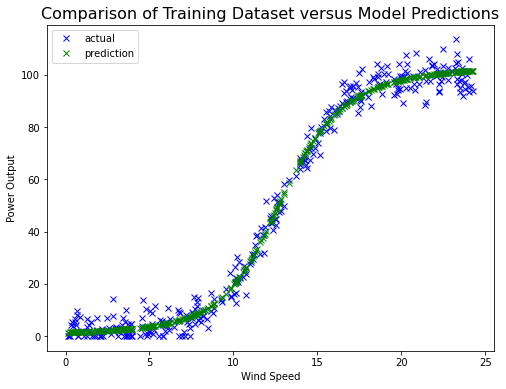

In [34]:
# Plot training dataset comparison
plt.plot(train['speed']*Speed_F, train['power']*Power_F, 'bx', label='actual')
plt.plot(train['speed']*Speed_F, model.predict(train['speed'])*Power_F, 'gx', label='prediction')
plt.title("Comparison of Training Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

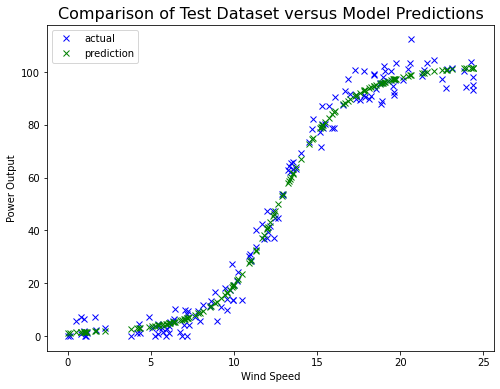

In [35]:
# Plot testing dataset comparison
plt.plot(test['speed']*Speed_F, test['power']*Power_F, 'bx', label='actual')
plt.plot(test['speed']*Speed_F, model.predict(test['speed'])*Power_F, 'gx', label='prediction')
plt.title("Comparison of Test Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

In [36]:
# Testing of the model prediction
print(f"Wind speed of 20 using the Keras Main model gives power of: {round(model.predict([20/Speed_F])[0][0]*Power_F, 3)}")


Wind speed of 20 using the Keras Main model gives power of: 97.949


<b>Save the Neural Network Model</b>

In [37]:
#model.save("Model_NN.h5")
print("Neural network model saved as Model_NN.h5")

Neural network model saved as Model_NN.h5


In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("Model_NN.json", "w") as json_file:
    json_file.write(model_json)
print("Neural network model saved as Model_NN.json")

Neural network model saved as Model_NN.json


### Model Accuracy of the Training data

<b>Accuracy</b> is the mearsurement used in Machine Learning to determine the performance by identifying relationships and patterns between variables in the dataset based on the input, or training data. It is very important to make practical decisions and more accurate models will give better results.[13]

In this section I am going to use my train dataset to figure out the accuracy of the model and loss curve. Since the 

A <b>loss function</b> is used to optimize a machine learning algorithm. The loss is calculated on training and validation and its interpretation is based on how well the model is doing in these two sets. It is the sum of errors made for each example in training or validation sets. Loss value implies how poorly or well a model behaves after each iteration of optimization.

An <b>accuracy metric</b> is used to measure the algorithm’s performance in an interpretable way. The accuracy of a model is usually determined after the model parameters and is calculated in the form of a percentage. It is the measure of how accurate your model's prediction is compared to the true data

In [39]:
# Normalise the data for use in Keras neural network models

# Set normalisation factors [12]
Speed_F = 25
Power_F = 120

# Apply normalisation to the input speeds
Power_data_Normalise = Power_data.copy()
Power_data_Normalise['speed'] = Power_data_Normalise['speed']/Speed_F
Power_data_Normalise['power'] = Power_data_Normalise['power']/Power_F

# Divide the data into training and testing sets. Code adapted from
# https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/
# Creating a training dataframe with 70% ratio of
train = Power_data_Normalise.sample(frac = 0.7)
  
# Creating testing dataframe with rest of the 30% values 
test = Power_data_Normalise.drop(train.index)

#code adopted from https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/
# Need x and y in correct format.
X = Power_data[["speed"]] # note dimensions
y = Power_data["power"]

# Split the data set into train/set. 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Take some of the training set to be a validation set. 25% of 80 = 60 
# Want train:test:validation = 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)


In [40]:
# Create basic Keras main model Code adpted from https://stackoverflow.com/a/59148584
model_Accuracy = kr.models.Sequential()
# Add 1st Hidden layer
model_Accuracy.add(kr.layers.Dense(20, input_shape=(1,), activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add 2nd Hidden layer
model_Accuracy.add(kr.layers.Dense(20, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add Output layer
model_Accuracy.add(kr.layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Compile model

#model.compile(optimizer, loss, metrics=<a list of metrics you would like to use>)
#model_Accuracy.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Accuracy.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print("Keras Main Model Summary")
print("============================")
model_Accuracy.summary()


Keras Main Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Train the Keras main model on the training dataset.
#history_MAccuracy = model_Accuracy.fit(train['speed'], train['power'],  epochs=500, batch_size=10, 
#    validation_data=(X_test, y_test))
#history_MAccuracy = model_Accuracy.fit(train['speed'], train['power'], epochs=len(X_train), batch_size=10)
#history_MAccuracy = model_Accuracy.fit(train['speed'], train['power'], epochs=500, batch_size=10)


#code adopted from https://stackoverflow.com/questions/63547276/why-val-loss-and-val-accuracy-not-showing-in-epochs
history_MAccuracy = model_Accuracy.fit(train['speed'], train['power'], epochs=35, batch_size=10,verbose=1, validation_data=(train['speed'], train['power']))


Epoch 1/35
34/34 [==============================] - 1s 21ms/step - loss: 0.2897 - accuracy: 0.0000e+00 - val_loss: 0.2175 - val_accuracy: 0.0000e+00
Epoch 2/35
34/34 [==============================] - 0s 1ms/step - loss: 0.2182 - accuracy: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.0000e+00
Epoch 3/35
34/34 [==============================] - 0s 1ms/step - loss: 0.1441 - accuracy: 0.0116 - val_loss: 0.1189 - val_accuracy: 0.0559
Epoch 4/35
34/34 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.0608 - val_loss: 0.1156 - val_accuracy: 0.0559
Epoch 5/35
34/34 [==============================] - 0s 1ms/step - loss: 0.1170 - accuracy: 0.0682 - val_loss: 0.1145 - val_accuracy: 0.0559
Epoch 6/35
34/34 [==============================] - 0s 1ms/step - loss: 0.1156 - accuracy: 0.0609 - val_loss: 0.1135 - val_accuracy: 0.0559
Epoch 7/35
34/34 [==============================] - 0s 1ms/step - loss: 0.1157 - accuracy: 0.0363 - val_loss: 0.1125 - val_accuracy: 0.0559
Epo

In [42]:
# list all data in history
print(history_MAccuracy.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<b>Model's Accuracy Plot</b>

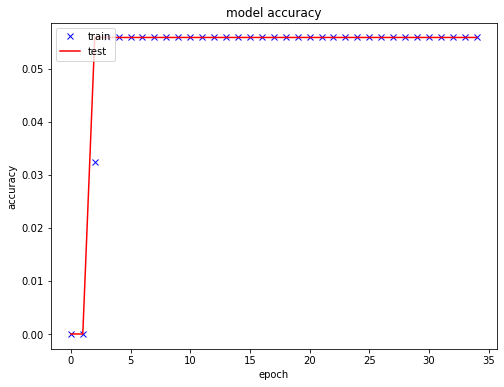

In [43]:
# summarize history for accuracy
plt.plot(history_MAccuracy.history['accuracy'],'bx')
plt.plot(history_MAccuracy.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


From the plot of accuracy we can see that the trained set of the model has a great accuracy where there is no gap between the trained and test epochs. Usually a great accuracy wtih low loss in the model means that it is a best model to predict correct values. 

<b>Model's Loss curve Plot</b>

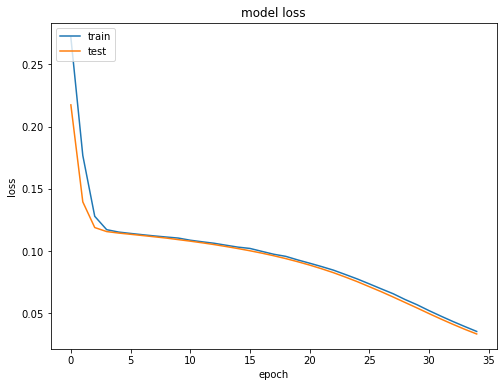

In [44]:
# summarize history for loss
plt.plot(history_MAccuracy.history['loss'])
plt.plot(history_MAccuracy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The above curve shows that it is a good fit on the model. We can see that the trainig and test loss decreases to a point of stability with a minimal gap between the two final loss values. It also seems that the loss of the test dataset decreases to a point of stability and has a small gap with the traning loss.

Since we have a great accuracy on the model with very low level of loss, the predictions from this training model will give most accurate results.

### Code used for Flask Application

In [46]:
# Function to predict power output based on inputted wind speeds using Keras Main Model
def power_output(windspeeds):
    """ Function to predict power output based on inputted wind speeds
      Acceptable inputs include numbers or a list of numbers
    """
    # Set the cut off wind speeds
    minWS, maxWS = 3, 24.5
    Speed_F=25
    Power_F=120
    # If wind speed is inside the cut off levels
    if windspeeds > minWS and windspeeds < maxWS:
      ws = np.array([windspeeds])
      return round(model.predict([ws/Speed_F])[0][0]*Power_F, 3)
    else:
      
      return 0

In [50]:
# Testing of function for single number values
ws_test = 20
print(f"Wind speed: {ws_test} gives power: {power_output(ws_test)}")
 

Wind speed: 20 gives power: 97.949


<b>References:</b>

[1]. The Power of the Wind: Cube of Wind Speed, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/enrspeed.htm

[2]. The Power Curve of a Wind Turbine, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/pwr.htm

[3]. Wind Turbine Power Curve, https://www.windfarmbop.com/wind-power-plant-concepts-and-performance-indicators/wind-turbine-power-curve/

[4]. How Do Wind Turbines Survive Severe Storms?; Office of ENERGY EFFICIENCY & RENEWABLE ENERGY - USA; https://www.energy.gov/eere/articles/how-do-wind-turbines-survive-severe-storms

[5].Simple Linear Regression, https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2

[6] Machine learning methods for wind turbine condition monitoring: A review, https://www.sciencedirect.com/science/article/pii/S096014811831231X

[6] Deep Learning, https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/ 

[7] Machine Learning Mastery, How To Build Multi-Layer Perceptron Neural Network Models with Keras , https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/

[8] Machine learning methods for wind turbine condition monitoring: A review,  https://www.sciencedirect.com/science/article/pii/S096014811831231X

[9] Understanding Activation Functions in Neural Networks, https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0

[10] A Gentle Introduction to the Rectified Linear Unit (ReLU), https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better.

[11] ReLU, Sigmoid and Tanh: today’s most used activation functions https://www.machinecurve.com/index.php/2019/09/04/relu-sigmoid-and-tanh-todays-most-used-activation-functions/

[12] Data Cleaning Challenge: Scale and Normalize Data, https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data

[13] Machine Learning Model Accuracy, https://www.datarobot.com/wiki/accuracy/#:~:text=What%20does%20Machine%20Learning%20Model,input%2C%20or%20training%2C%20data.


<b>References for Programming</b>

[1] Virtual Environments in Python Made Easy, https://www.sitepoint.com/virtual-environments-python-made-easy/#:~:text=And%20to%20delete%20a%20virtual,directory%20you%20want%20to%20delete.

[2] Linear Regression in Python, https://realpython.com/linear-regression-in-python/https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot

[3] Linear Regression (Python Implementation), https://www.geeksforgeeks.org/linear-regression-python-implementation/

[4] How to Build and Train Linear and Logistic Regression ML Models in Python, https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

[5] Linear Regression in Puthon with Scikit-Learn, https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

[6] Model Training APIs, https://keras.io/api/models/model_training_apis/

[7] Keras Tutorial: Deep Learning in Python, https://www.datacamp.com/community/tutorials/deep-learning-python

[8] ML Project in Python with Keras Step-By-Step,  https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
